In [1]:
import numpy as np
import astropy.units as u
import astropy.io.fits as fits
import matplotlib.pyplot as plt

import poppy

from gmagaox.imshows import *

from gmagaox.math_module import xp, ensure_np_array

wavelength = 650*u.nm
diam = 25.4*u.m
npix = 4096

pxscl = 25.4*u.m/npix
max_sf = 1/pxscl/2

wf = poppy.FresnelWavefront(beam_radius=diam/2, npix=npix, oversample=1)

def psd_model(k, psd_parm):
    # k: array/matrix of spatial frequencies
    # psd_parm: list with the PSD parameters
    alpha = psd_parm[0]
    beta = psd_parm[1]
    oscl = psd_parm[2]
    iscl = psd_parm[3]
    bsr = psd_parm[4]
    if oscl.value != 0:
        denom = ( ((1/oscl)**2) + (k**2))**(alpha/2)
    else: # explosion prevention
        denom = (k**2)**(alpha/2)
    pk = ((beta/denom) * np.exp(-((k.value*iscl)**2))) + bsr
    return pk


Oversampling > 2x suggested for reliable results in Fresnel propagation.


In [2]:
pxscl = 25.4*u.m/800 
max_sf = 1/pxscl/2
max_sf

<Quantity 15.7480315 1 / m>

Text(0.5, 1.0, 'Example PSD distribution')

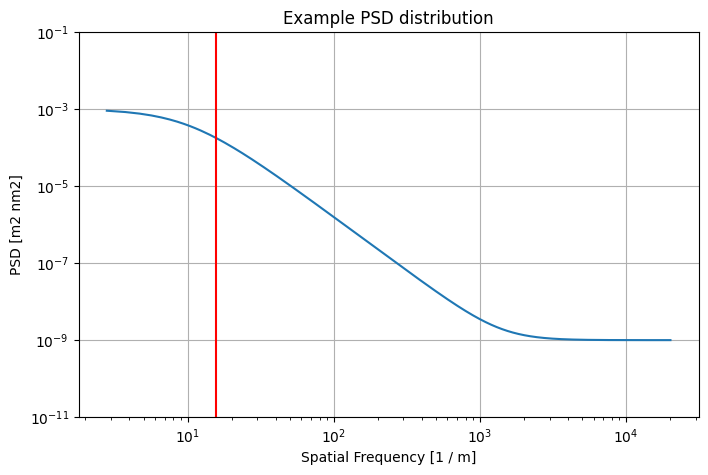

In [3]:
alpha = 2.8
psd_params = {
    'alpha':alpha,
    'beta':0.637*u.nm**2 / (u.m**(alpha-2)),
    'outer_scale':0.1*u.m,
    'inner_scale':1e-4,
    'surf_roughness':1e-9 * u.m**2 * u.nm**2,
}

psd_list = [[psd_params['alpha'], psd_params['beta'],
             psd_params['outer_scale'], psd_params['inner_scale'], psd_params['surf_roughness']]]
psd_weight = [1]
incident_angle = 0*u.degree

seed = 123456
screen_size = int(npix*1)

k_range = (np.arange(start=2.8, stop=20176, step=0.95)/u.m)
psd1 = psd_model(k_range, psd_list[0])

plt.figure(figsize=[8,5], dpi=100)
plt.loglog(k_range.value, psd1.value)
plt.vlines(max_sf.to_value(1/u.m), 1e-11, 1e-1, color='red')
plt.grid()
plt.ylim(top=0.1, bottom=1e-11)
plt.xlabel('Spatial Frequency [{0}]'.format(k_range.unit))
plt.ylabel('PSD [{0}]'.format(psd1.unit))
plt.title('Example PSD distribution')


In [ ]:
diam = 6.5*u.mm

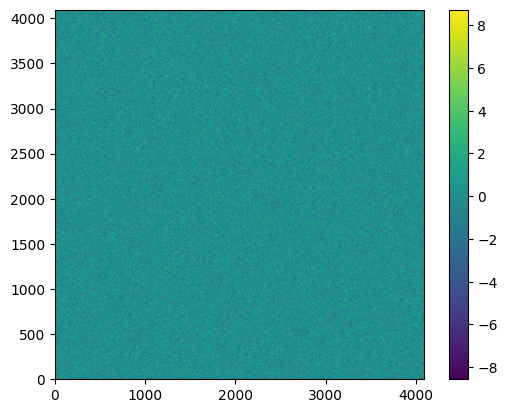

In [4]:

wfe = poppy.PowerSpectrumWFE(psd_parameters=psd_list, 
                             psd_weight=psd_weight,
                             incident_angle=incident_angle,
                             apply_reflection=True,
                             seed=seed, 
                             screen_size=screen_size,
                            )

psd_opd = wfe.get_opd(wf)*1e9

plt.imshow(ensure_np_array(psd_opd))
plt.colorbar()

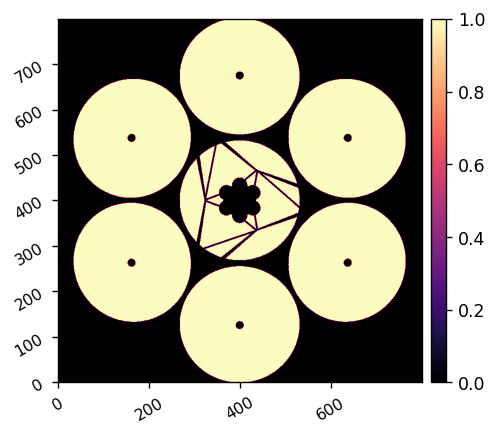

In [10]:
pupil_fpath = 'gmagaox/data/gmt_pupil_800.fits'
pupil = fits.getdata(pupil_fpath)
pupil_info = fits.getheader(pupil_fpath)
imshow1(pupil)

In [11]:
pupil_info

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                  800 / length of data axis 1                          
NAXIS2  =                  800 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
SCALE   =   0.0317481662591687 / Scale in m/pixel                               
CENTER  =                  399 / Center pixel (NxN), counting from 0            

In [12]:
0.0317481662591687*800

25.39853300733496